<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Решение-с-дисбалансом" data-toc-modified-id="Решение-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Решение с дисбалансом</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#imblearn" data-toc-modified-id="imblearn-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>imblearn</a></span></li><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Downsampling</a></span><ul class="toc-item"><li><span><a href="#Разобью-выборку-на-обучающую,-тестовую-и-валидационную" data-toc-modified-id="Разобью-выборку-на-обучающую,-тестовую-и-валидационную-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Разобью выборку на обучающую, тестовую и валидационную</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование-модели-(GridSearch)" data-toc-modified-id="Тестирование-модели-(GridSearch)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели (GridSearch)</a></span></li><li><span><a href="#Моя-гипотеза-с-другими-фичами" data-toc-modified-id="Моя-гипотеза-с-другими-фичами-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Моя гипотеза с другими фичами</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [214]:
#!pip install XGBoost
!pip install --upgrade scikit-learn
!pip install -U imbalanced-learn
!pip install -U scikit-learn

In [215]:
from scipy.stats import chi2_contingency
from sklearn.metrics import RocCurveDisplay, f1_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

In [216]:
from imblearn.under_sampling import RandomUnderSampler

In [217]:
df = pd.read_csv('/datasets/Churn.csv')
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [219]:
df.isna().mean()

RowNumber          0.0000
CustomerId         0.0000
Surname            0.0000
CreditScore        0.0000
Geography          0.0000
Gender             0.0000
Age                0.0000
Tenure             0.0909
Balance            0.0000
NumOfProducts      0.0000
HasCrCard          0.0000
IsActiveMember     0.0000
EstimatedSalary    0.0000
Exited             0.0000
dtype: float64

Имеются пропуски в столбце Tenure, он показывает сколько лет человек является клиентом банка. Возможно пропуски связаны с тем, что клиент меньше года пользуется услугами банка

In [220]:
df[df['Tenure'] < 1].head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
29,30,15656300,Lucciano,411,France,Male,29,0.0,59697.17,2,1,1,53483.21,0
35,36,15794171,Lombardo,475,France,Female,45,0.0,134264.04,1,1,0,27822.99,1
57,58,15647091,Endrizzi,725,Germany,Male,19,0.0,75888.20,1,0,0,45613.75,0
72,73,15812518,Palermo,657,Spain,Female,37,0.0,163607.18,1,0,1,44203.55,0
127,128,15782688,Piccio,625,Germany,Male,56,0.0,148507.24,1,1,0,46824.08,1


In [221]:
df[df['Tenure'].isna() == True].head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


<AxesSubplot:>

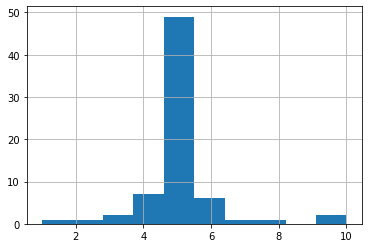

In [222]:
df.groupby('Age').mean()['Tenure'].hist()

In [223]:
piv = df.groupby('Tenure')['RowNumber'].agg(['count'])
piv

,count
Tenure,
0.0,382
1.0,952
2.0,950
3.0,928
4.0,885
5.0,927
6.0,881
7.0,925
8.0,933


<AxesSubplot:>

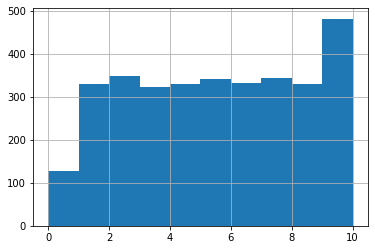

In [224]:
df[(df['Balance'] < 1)]['Tenure'].hist()

<AxesSubplot:>

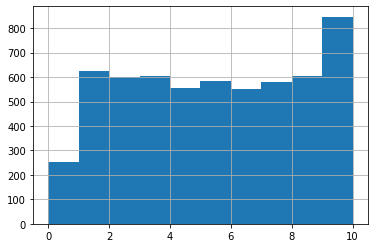

In [225]:
df[(df['Balance'] != 0)]['Tenure'].hist()

Те у кого нулевой баланс, не обязательно являются первогодними клиентами

In [226]:
df[(df['Balance'] < 1) & (df['Tenure'].isna() == True)].head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.0,3,1,0,140469.38,1
82,83,15641732,Mills,543,France,Female,36,NaN,0.0,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.0,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.0,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.0,2,0,0,6534.18,0


Сложно понять можно ли как-то логично заполнить данные пропуски, учитывая, что пропусков всего 9%, то я их просто оставлю.

## Исследование задачи

In [227]:
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(exclude='object').columns
num_cols

Index(['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

Поищем зависимости целевого признака

In [228]:
df.groupby('Surname')['Exited'].agg(['mean', 'count']
                                    ).sort_values(ascending=False, by='count')

,mean,count
Surname,,
Smith,0.281250,32
Martin,0.310345,29
Scott,0.103448,29
Walker,0.142857,28
Brown,0.192308,26
...,...,...
Etheridge,0.000000,1
Milliner,0.000000,1
Milligan,1.000000,1


Признак с именем стоит удалить из фичей. Он на мой взгляд добавит лишь шума для модели. Здесь есть как тезки так и единственные фамилии. Возможно, для людей с одной фамилией модель будет лучше составлять свзяи с целевым признаком, но не будет толку при новой фамилии. То есть этот признак только нагрузит модель вычеслительно, а толку не даст. К тому же, не все Смитты одинаковы, правда?)

Так как численные признаки бывают очень разбросанные, то я бы хотел их немного сгруппировать.

In [229]:
df_2 = df.drop(['CustomerId', 'Surname'], axis=1)
df_2 = df_2.set_index("RowNumber")
num_cols_2 = df_2.select_dtypes(exclude='object').columns

for i in num_cols_2:
    if df_2[i].mean() > 10:
        df_2[i] = (pd.qcut(df_2[i], 10, duplicates='drop'))

In [230]:
df_2

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,"(598.7, 627.0]",France,Female,"(40.0, 42.0]",2.0,"(-0.001, 73080.908]",1,1,1,"(100193.915, 119710.038]",1
2,"(598.7, 627.0]",Spain,Female,"(40.0, 42.0]",1.0,"(73080.908, 97198.54]",1,0,1,"(100193.915, 119710.038]",0
3,"(349.999, 521.0]",France,Female,"(40.0, 42.0]",8.0,"(149244.792, 250898.09]",3,1,0,"(100193.915, 119710.038]",1
4,"(678.0, 704.0]",France,Female,"(37.0, 40.0]",1.0,"(-0.001, 73080.908]",2,0,0,"(80238.34, 100193.915]",0
5,"(778.0, 850.0]",Spain,Female,"(42.0, 46.0]",2.0,"(122029.87, 133710.358]",1,1,1,"(60736.079, 80238.34]",0
...,...,...,...,...,...,...,...,...,...,...,...
9996,"(735.0, 778.0]",France,Male,"(37.0, 40.0]",5.0,"(-0.001, 73080.908]",2,1,0,"(80238.34, 100193.915]",0
9997,"(349.999, 521.0]",France,Male,"(33.0, 35.0]",10.0,"(-0.001, 73080.908]",1,1,1,"(100193.915, 119710.038]",0
9998,"(704.0, 735.0]",France,Female,"(35.0, 37.0]",7.0,"(-0.001, 73080.908]",1,0,1,"(41050.736, 60736.079]",1


In [231]:
df_2.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [232]:
pipe = make_pipeline(ColumnTransformer(transformers=[('ohe', OrdinalEncoder(),
                                                      ['CreditScore', 'Geography', 'Gender',
                                                       'Age', 'Balance', 'EstimatedSalary'])],
                                       remainder='passthrough'),

                     )
data_encoded = pd.DataFrame(pipe.fit_transform(df_2))

In [233]:
def cramers_V(var1, var2):
    # Cross table building
    crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
    # Keeping of the test statistic of the Chi2 test
    stat = chi2_contingency(crosstab)[0]
    obs = np.sum(crosstab)  # Number of observations
    # Take the minimum value between the columns and the rows of the cross table
    mini = min(crosstab.shape)-1
    return (stat/(obs*mini))

<AxesSubplot:>

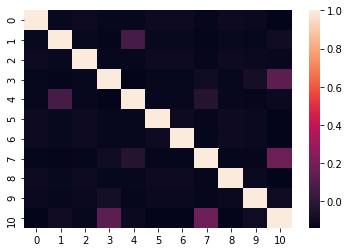

In [234]:
rows = []

for var1 in data_encoded:
    col = []
    for var2 in data_encoded:

        # Cramer's V test
        cramers = cramers_V(data_encoded[var1], data_encoded[var2])
        # Keeping of the rounded value of the Cramer's V
        col.append(round(cramers, 2))
    rows.append(col)

cramers_results = np.array(rows)
df_cramer = pd.DataFrame(
    cramers_results, columns=data_encoded.columns, index=data_encoded.columns)


sns.heatmap(df_cramer.corr())

Я хотел построить корреляцию по всему ДФ, Но во-первых не смог вытащить из пайалайна/колом трансформера названия колонок. Ну это ладно, в целом если это сработало правильно, то мы не имеем мультиколленарных фичей.

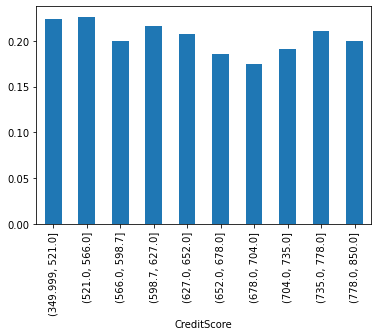

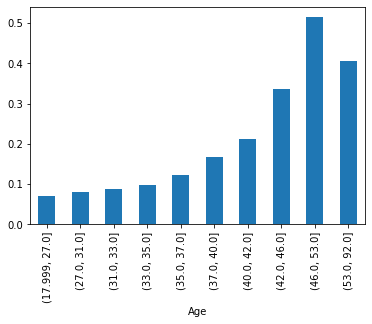

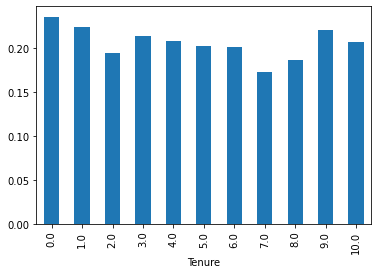

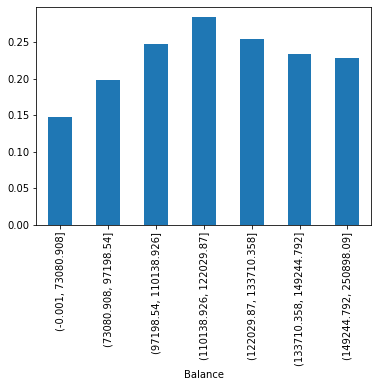

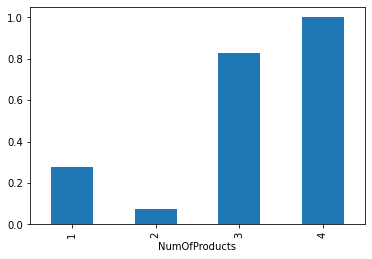

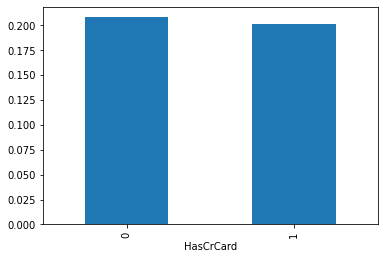

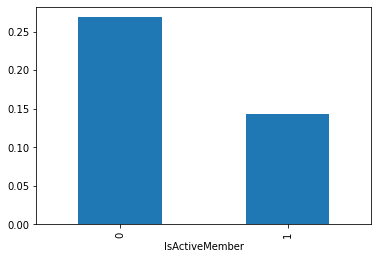

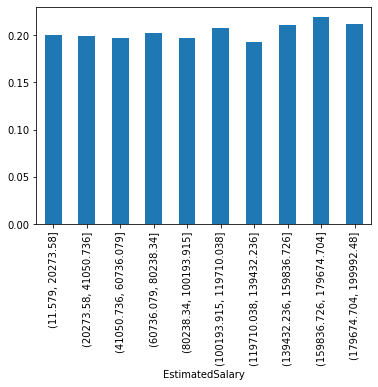

In [237]:
for i in num_cols_2[:-1]:
    df_2.groupby(i).mean()['Exited'].plot(kind='bar')

    plt.show()

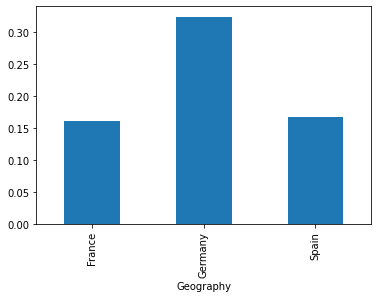

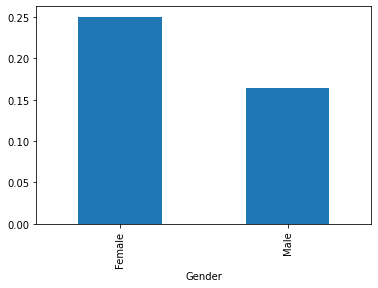

In [238]:
for i in cat_cols[1:]:
    df_2.groupby(i).mean()['Exited'].plot(kind='bar')

    plt.show()

По построенным графикам можно определить какие признаки влияют на на целевой признак а какие нет.

Так видно, что наблюдается зависимость от признаков Geography, Gander,NumOfProducts, IsActiveMember,Balance,Age. По этим данным отчетливо видна зависимость искомой переменной. Остальные выглядят как шумовые, или мало коррелируемые. 

Мое внимание привлек признак CreditScore, которые вроде бы как должен показывать кредитный рейтинг клиента. Но видимо уйдет ли клиент или нет не зависит от его кредитоплатежности.

## Решение с дисбалансом

In [239]:
data_dis = df.dropna().drop(
    ['RowNumber', 'Surname', 'CustomerId'], axis=1).copy()

Разобьем датасет на тестовую и тренеровочную выборку

In [240]:
data_train, data_test = train_test_split(
    data_dis, test_size=0.2, random_state=42)
print(data_train.shape, data_test.shape)

X_train1 = data_train.drop('Exited', axis=1)
y_train1 = data_train['Exited']

X_test1 = data_test.drop('Exited', axis=1)
y_test1 = data_test['Exited']


(7272, 11) (1819, 11)


In [241]:
Standart_scale_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
cat_cols = X_test1.select_dtypes(include='object').columns

Базовые модели для проверки

In [242]:
rf=RandomForestClassifier(random_state=42)
xgbs=GradientBoostingClassifier(random_state=42)
lreg=LogisticRegression(random_state=42)

In [243]:
models=[rf,xgbs,lreg]
for i in models:
    pipe_dis = make_pipeline(ColumnTransformer(transformers=[('sts', StandardScaler(), Standart_scale_cols),
                                                         ('ohe', OneHotEncoder(), cat_cols)],
                                           remainder='passthrough'),i)
    print(i,cross_val_score(pipe_dis,X_train1, y_train1,cv=5, scoring='f1').mean())

RandomForestClassifier(random_state=42) 0.5702077517864984
GradientBoostingClassifier(random_state=42) 0.5897486237382848
LogisticRegression(random_state=42) 0.3136218897816902


оптимальные модели GradientBoostingClassifier  и RandomForestClassifier

In [244]:
GradientBoostingClassifiermodels=[rf,xgbs]
#pipe_dis.fit(X_train1, y_train1)
#roc_auc_score(y_test1, pipe_dis.predict_proba(X_test1)[:, -1])

f1-мера с дисбалансом класса показывает просто ужасные значения 0,55- это нужно исправлять.

Что интересно, roc_auc не такой и низкий...

Подберем параметры для моделей

In [245]:
from sklearn.utils.fixes import loguniform

In [246]:
#RandomForest
param_grid = {'n_estimators': range(70, 120, 5),
              'max_depth':np.arange(1, 12, 1),
              'min_samples_split':range(2, 6),
              'min_samples_leaf':range(1, 3),
              'class_weight':[None, 'balanced']
             }
grd_rf = RandomizedSearchCV(rf, param_distributions=param_grid,cv=5, scoring='f1', n_jobs=4,random_state=42)
pipe_grd_rf = make_pipeline(ColumnTransformer(transformers=[('sts', StandardScaler(), Standart_scale_cols),
                                                           ('ohe', OneHotEncoder(), cat_cols)],
                                             remainder='passthrough'),
                           grd_rf)

pipe_grd_rf.fit(X_test1,y_test1)
print(grd_rf.best_score_,grd_rf.best_params_)

0.5625044023795596 {'n_estimators': 90, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 6, 'class_weight': 'balanced'}


In [247]:
param_grid2 = {'learning_rate': np.arange(0.19, 0.29, 0.01),
              'max_depth': np.arange(1, 25, 1),
               'n_estimators':np.arange(125, 150, 5),
               'min_samples_split':range(2,6),
               'min_samples_leaf':range(1,3),
               'loss': [ 'deviance', 'exponential']
              }

grd_xg = RandomizedSearchCV(xgbs, param_distributions=param_grid2,cv=5, scoring='f1', n_jobs=8,random_state=42, verbose=False)
pipe_grd_xg = make_pipeline(ColumnTransformer(transformers=[('sts', StandardScaler(), Standart_scale_cols),
                                                           ('ohe', OneHotEncoder(), cat_cols)], 
                                             remainder='passthrough'),
                           grd_xg)


pipe_grd_xg.fit(X_test1,y_test1)
print(grd_xg.best_score_,grd_xg.best_params_)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  war

0.5330336257309942 {'n_estimators': 125, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 11, 'loss': 'deviance', 'learning_rate': 0.2700000000000001}


## Борьба с дисбалансом

Как мы все знаем есть два варианта борьбы с дисбалансом. Это upscale, и downscale. Я использую downscale. Так как мне кажется так у нас получится наиболее "честная" выборка. А когда мы будем копировать при помощи upscale, то мне кажется это грозит утечке фичей в тест и валди выборку. Может я не прав поправьте, но downscale звучит логичнее

### imblearn

In [248]:
from imblearn.under_sampling import RandomUnderSampler

In [249]:
data_imb = df.dropna().drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)
data_train_i, data_test_i = train_test_split(
    data_imb, test_size=0.2, random_state=42)

X_train_imb = data_train_i.drop('Exited', axis=1)
y_train_imb = data_train_i['Exited']

X_test_imb = data_test_i.drop('Exited', axis=1)
y_test_imb = data_test_i['Exited']

In [250]:
X_train_imb.shape

(7272, 10)

In [251]:
X_resampled, y_resampled = RandomUnderSampler(
    random_state=42).fit_resample(X_train_imb, y_train_imb)

In [252]:
y_resampled.value_counts()

0    1480
1    1480
Name: Exited, dtype: int64

In [253]:
param_grid = {'n_estimators': range(70, 120, 5),
              'max_depth':np.arange(1, 12, 1),
              'min_samples_split':range(2, 6),
              'min_samples_leaf':range(1, 3),
              'class_weight':[None, 'balanced']
             }
grd_rf = RandomizedSearchCV(rf, param_distributions=param_grid,cv=5, scoring='f1', n_jobs=4,random_state=42)
pipe_grd_rf = make_pipeline(ColumnTransformer(transformers=[('sts', StandardScaler(), Standart_scale_cols),
                                                           ('ohe', OneHotEncoder(), cat_cols)],
                                             remainder='passthrough'),
                           grd_rf)

pipe_grd_rf.fit(X_resampled,y_resampled)
print(grd_rf.best_score_,grd_rf.best_params_)

0.7709543623948714 {'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 11, 'class_weight': None}


In [255]:
param_grid2 = {'learning_rate': np.arange(0.19, 0.29, 0.01),
              'max_depth': np.arange(1, 25, 1),
               'n_estimators':np.arange(125, 150, 5),
               'min_samples_split':range(2,6),
               'min_samples_leaf':range(1,3),
               'loss': [ 'deviance', 'exponential']
              }

grd_xg = RandomizedSearchCV(xgbs, param_distributions=param_grid2,cv=5, scoring='f1', n_jobs=8,random_state=42, verbose=False)
pipe_grd_xg = make_pipeline(ColumnTransformer(transformers=[('sts', StandardScaler(), Standart_scale_cols),
                                                           ('ohe', OneHotEncoder(), cat_cols)], 
                                             remainder='passthrough'),
                           grd_xg)


pipe_grd_xg.fit(X_resampled,y_resampled)
print(grd_xg.best_score_,grd_xg.best_params_)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  war

0.7617328334069742 {'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1, 'loss': 'exponential', 'learning_rate': 0.26000000000000006}


При помощи борьбы с дисбалансом методом RandomUnderSampler удалось повысить точность по f1 мере до 0,77 у RandomForesta и до 0.76 у GradientBosstinga

OverSampling

In [256]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [257]:
ctm = ColumnTransformer(
    transformers=[('ord', OrdinalEncoder(), cat_cols)], remainder='passthrough')
pipe_over = Pipeline([('columntr', ctm),
                      ('smote', SMOTE(random_state=42)),
                      ('RandForest', grd_rf.best_estimator_)])

In [258]:
pipe_over.fit(X_train_imb, y_train_imb)

Pipeline(steps=[('columntr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord', OrdinalEncoder(),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('RandForest',
                 RandomForestClassifier(max_depth=11, min_samples_leaf=2,
                                        min_samples_split=4, n_estimators=70,
                                        random_state=42))])

### Downsampling

<AxesSubplot:>

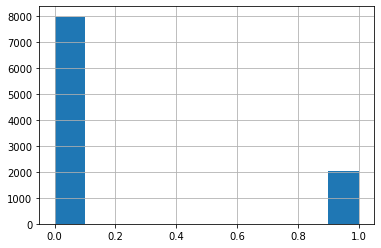

In [259]:
df['Exited'].hist()

In [260]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Видно, что данные сильно не сбалансированы в соотношении 1к4
Попробую применить downsampling, и уберем лишние данные клиентов, которые остались

In [261]:
data_test = df.copy()

In [262]:
data = df.dropna().drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)
data[data['Exited'] == 0] = data[data['Exited']
                                 == 0].sample(frac=0.25, random_state=42)
data = data.dropna()

In [263]:
data['Exited'].value_counts(normalize=True)

1.0    0.506143
0.0    0.493857
Name: Exited, dtype: float64

In [264]:
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,France,Female,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,1.0
1,608.0,Spain,Female,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0
2,502.0,France,Female,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0
5,645.0,Spain,Male,44.0,8.0,113755.78,2.0,1.0,0.0,149756.71,1.0
7,376.0,Germany,Female,29.0,4.0,115046.74,4.0,1.0,0.0,119346.88,1.0
...,...,...,...,...,...,...,...,...,...,...,...
9987,606.0,Spain,Male,30.0,8.0,180307.73,2.0,1.0,1.0,1914.41,0.0
9991,597.0,France,Female,53.0,4.0,88381.21,1.0,1.0,0.0,69384.71,1.0
9992,726.0,Spain,Male,36.0,2.0,0.00,1.0,1.0,0.0,195192.40,0.0
9997,709.0,France,Female,36.0,7.0,0.00,1.0,0.0,1.0,42085.58,1.0


<AxesSubplot:>

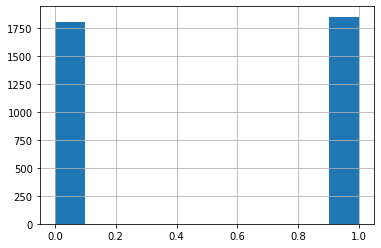

In [265]:
data['Exited'].hist()

In [266]:
data.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,France,Female,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,1.0
1,608.0,Spain,Female,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0
2,502.0,France,Female,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0


прекрасно

Я бы еще проверил что будет если применить class_weight=balanced в модели

Я убираю фичи 'RowNumber','Surname','CustomerId', так они не влияют на решения моедели(разве что в худшую сторону)

Я имею гипотезу, что наилучший результат покажет модель с фичами Geography, Gander,NumOfProducts, IsActiveMember,Balance,Age. возможно потом ее проверю

In [267]:
data.isna().mean()

CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

In [268]:
X = data.drop('Exited', axis=1)
y = data['Exited']
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

In [269]:
pipe = make_pipeline(ColumnTransformer(transformers=[('sts', StandardScaler(), Standart_scale_cols),
                                                     ('ohe', OneHotEncoder(), cat_cols)],
                                       remainder='passthrough')
                     )
pd.DataFrame(pipe.fit_transform(X))

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.305660,0.078704,-1.324104,0.024120,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0
1,-0.418462,-0.015141,0.040167,0.218021,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
2,-1.505463,0.078704,1.274945,0.242081,1.0,0.0,0.0,1.0,0.0,8.0,3.0,1.0,0.0
3,-0.039037,0.266395,0.527677,0.862655,0.0,0.0,1.0,0.0,1.0,8.0,2.0,1.0,0.0
4,-2.797560,-1.141285,0.548692,0.335887,0.0,1.0,0.0,1.0,0.0,4.0,4.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3658,-0.438971,-1.047440,1.611047,-1.698314,0.0,0.0,1.0,0.0,1.0,8.0,2.0,1.0,1.0
3659,-0.531264,1.111003,0.114615,-0.529573,1.0,0.0,0.0,1.0,0.0,4.0,1.0,1.0,0.0
3660,0.791596,-0.484368,-1.324104,1.649706,0.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0
3661,0.617266,-0.484368,-1.324104,-1.002457,1.0,0.0,0.0,1.0,0.0,7.0,1.0,0.0,1.0


Вот этот датафрейм будем кормить моделькам. 

#### Разобью выборку на обучающую, тестовую и валидационную

In [270]:
data_train, data_test  = train_test_split(
    data, test_size=0.2, random_state=42)
print(data_train.shape,  data_test.shape)

(2930, 11) (733, 11)


Поделил выборку на обучающую:тестовую:валидационную как 60:20:20

In [271]:
X_train = data_train.drop('Exited', axis=1)
y_train = data_train['Exited']

X_test = data_test.drop('Exited', axis=1)
y_test = data_test['Exited']


In [272]:
X_test

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
3955,625.0,France,Male,39.0,2.0,0.00,2.0,1.0,0.0,100403.05
236,712.0,France,Female,29.0,2.0,0.00,1.0,1.0,1.0,144375.00
797,488.0,Germany,Male,32.0,3.0,114540.38,1.0,1.0,0.0,92568.07
9376,567.0,France,Female,47.0,2.0,0.00,1.0,0.0,0.0,110900.43
8424,702.0,France,Male,26.0,2.0,71281.29,1.0,1.0,1.0,108747.12
...,...,...,...,...,...,...,...,...,...,...
164,683.0,Spain,Male,29.0,0.0,133702.89,1.0,1.0,0.0,55582.54
4935,505.0,Germany,Male,43.0,6.0,127146.68,1.0,0.0,0.0,137565.87
9856,763.0,Germany,Female,32.0,1.0,108465.65,2.0,1.0,0.0,60552.44
6249,705.0,France,Female,48.0,0.0,0.00,2.0,0.0,0.0,149772.61


In [273]:
models = [RandomForestClassifier, DecisionTreeClassifier, LogisticRegression]
num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [274]:
def model_testing(X_train, y_train, X_test, y_test, models, metric, num_cols,
                  cat_cols=X_train.select_dtypes(include='object').columns):

    f1_score_val = 0
    roc_auc_valid = 0
    pipe_0 = make_pipeline(ColumnTransformer(transformers=[('sts', StandardScaler(), Standart_scale_cols),
                                                           ('ohe', OneHotEncoder(), cat_cols)], remainder='passthrough'))

    for i in models:

        pipe = make_pipeline(pipe_0, i(random_state=42))
        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_valid)
        f1 = f1_score(y_valid, pred)
        roc = roc_auc_score(y_valid, pipe.predict_proba(X_valid)[:, -1])

        if metric == 'roc_auc':
            if roc > roc_auc_valid:
                f1_score_val = f1
                best_model = pipe
                roc_auc_valid = roc
        if metric == 'f1_score':
            if f1 > f1_score_val:
                f1_score_val = f1
                best_model = pipe
                roc_auc_valid = roc
    return f1_score_val, roc_auc_valid, best_model

In [275]:
f1_score_val, roc_auc_valid, mod = model_testing(
    X_train, y_train, X_test, y_test, models, metric='f1_score', num_cols=num_cols)

In [276]:
mod, 'roc_auc', roc_auc_valid, 'f1_score', f1_score_val

(Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(remainder='passthrough',
                                                     transformers=[('sts',
                                                                    StandardScaler(),
                                                                    ['CreditScore',
                                                                     'Age',
                                                                     'Balance',
                                                                     'EstimatedSalary']),
                                                                   ('ohe',
                                                                    OneHotEncoder(),
                                                                    Index(['Geography', 'Gender'], dtype='object'))]))])),
                 ('randomforestclassifier',
                  

Лучшая модель из коробки - RandomForestClassifier. XGBClassifier чет ругается

## Тестирование модели (GridSearch)

Возьмем выборки, которые были избавлены от дисбаланса при помощи бибилиотеки imblearn

In [277]:
X_resampled_train, y_resampled_train = RandomUnderSampler(
    random_state=42).fit_resample(X_train_imb, y_train_imb)
X_train=X_resampled_train
y_train=y_resampled_train

X_resampled_test, y_resampled_test = RandomUnderSampler(
    random_state=42).fit_resample(X_test_imb, y_test_imb)
X_test=X_resampled_test
y_test=y_resampled_test

In [278]:
X_test

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,742,Germany,Male,33,0.0,181656.51,1,1,1,107667.91
1,627,Germany,Male,52,1.0,76101.81,2,0,1,177238.35
2,850,France,Male,35,2.0,0.00,2,1,1,56991.66
3,676,Germany,Male,28,1.0,69459.05,2,1,1,128461.29
4,654,France,Male,29,1.0,0.00,1,1,0,180345.44
...,...,...,...,...,...,...,...,...,...,...
743,629,France,Male,59,9.0,113657.83,1,1,1,116848.79
744,688,Spain,Female,33,2.0,0.00,1,0,0,27557.18
745,781,France,Male,38,2.0,117810.79,1,0,1,65632.33
746,601,France,Female,40,3.0,92055.36,1,0,1,164652.02


X_test_imb 
y_test_imb

И теперь протестируем лучшую модели на тестовых выборках

In [279]:
param_grid = {'n_estimators': range(70, 120, 5),
              'max_depth':np.arange(1, 12, 1),
              'min_samples_split':range(2, 6),
              'min_samples_leaf':range(1, 3),
              'class_weight':[None, 'balanced']
             }
grd_rf = RandomizedSearchCV(rf, param_distributions=param_grid,cv=5, scoring='f1', n_jobs=4,random_state=42)
pipe_grd_rf = make_pipeline(ColumnTransformer(transformers=[('sts', StandardScaler(), Standart_scale_cols),
                                                           ('ohe', OneHotEncoder(), cat_cols)],
                                             remainder='passthrough'),
                           grd_rf)

pipe_grd_rf.fit(X_resampled_train,y_resampled_train)
print(grd_rf.best_score_,grd_rf.best_params_)

0.7709543623948714 {'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 11, 'class_weight': None}


In [280]:
ctm = ColumnTransformer(
    transformers=[('ord', OrdinalEncoder(), cat_cols)], remainder='passthrough')
pipe_over = Pipeline([('columntr', ctm),
                      ('smote', SMOTE(random_state=42)),
                      ('RandForest', grd_rf.best_estimator_)])
pipe_over.fit(X_train,y_train)

Pipeline(steps=[('columntr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord', OrdinalEncoder(),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('RandForest',
                 RandomForestClassifier(max_depth=11, min_samples_leaf=2,
                                        min_samples_split=4, n_estimators=70,
                                        random_state=42))])

In [281]:
print('__'*36)
print(grd_rf.best_params_)

print('__'*36)
print('тестовая выборка:',
      classification_report(y_test, pipe_over.predict(X_test))
      )
print('__'*36)
print('Roc_Auc', roc_auc_score(y_test, pipe_over.predict_proba(X_test)[:, -1]))

________________________________________________________________________
{'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 11, 'class_weight': None}
________________________________________________________________________
тестовая выборка:               precision    recall  f1-score   support

           0       0.75      0.79      0.77       374
           1       0.78      0.74      0.76       374

    accuracy                           0.76       748
   macro avg       0.76      0.76      0.76       748
weighted avg       0.76      0.76      0.76       748

________________________________________________________________________
Roc_Auc 0.8422531384940949


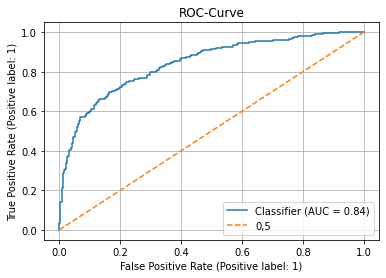

In [282]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    y_test, pipe_over.predict_proba(X_test)[:, -1], ax=ax)
ax.plot([0, 1], [0, 1], label='0,5', linestyle='--')
ax.set_title('ROC-Curve')
ax.grid(True)
plt.legend()
plt.show()

По итогу на тесте было получено f1 -мера 0,76, и roc_auc_score  0.842

## Моя гипотеза с другими фичами

Я имею гипотезу, что наилучший результат покажет модель с фичами Geography, Gender,NumOfProducts, IsActiveMember,Balance,Age. возможно потом ее проверю

In [283]:
data2 = data[['Geography', 'Gender', 'NumOfProducts',
              'IsActiveMember', 'Balance', 'Age', 'Exited']].copy()
data_train, data_tes_val = train_test_split(
    data2, test_size=0.4, random_state=42)
data_valid, data_test = train_test_split(
    data_tes_val, test_size=0.5, random_state=42)
print(data_train.shape, data_valid.shape, data_test.shape)

X_train2 = data_train.drop('Exited', axis=1)
y_train2 = data_train['Exited']

X_test2 = data_test.drop('Exited', axis=1)
y_test2 = data_test['Exited']

X_valid2 = data_valid.drop('Exited', axis=1)
y_valid2 = data_valid['Exited']

(2197, 7) (733, 7) (733, 7)


In [284]:
X_train2

,Geography,Gender,NumOfProducts,IsActiveMember,Balance,Age
7240,France,Female,1.0,0.0,98877.95,32.0
6023,France,Female,1.0,1.0,83036.05,33.0
3658,France,Female,1.0,0.0,80764.03,43.0
3406,Spain,Female,1.0,0.0,80922.75,29.0
894,Germany,Female,2.0,0.0,125884.95,35.0
...,...,...,...,...,...,...
3000,France,Female,2.0,1.0,0.00,40.0
3435,Germany,Female,1.0,1.0,89437.03,34.0
2265,France,Female,2.0,0.0,0.00,35.0
9558,Spain,Male,1.0,0.0,0.00,46.0


In [285]:
Standart_scale_cols = ['Age', 'Balance']
cat_cols = X_train2.select_dtypes(include='object').columns

In [286]:
param_grid2 = {'criterion': ['gini', 'entropy'],
               'n_estimators': np.arange(46, 60, 1),
               'max_depth': np.arange(5, 10, 1),
               }

grd2 = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid2,
                    cv=5, scoring='f1', n_jobs=-1)
pipe_grd2 = make_pipeline(ColumnTransformer(transformers=[('sts', StandardScaler(), Standart_scale_cols),
                                                          ('ohe', OneHotEncoder(), cat_cols)], remainder='passthrough'),
                          grd2)

pipe_grd2.fit(X_train2, y_train2)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('sts', StandardScaler(),
                                                  ['Age', 'Balance']),
                                                 ('ohe', OneHotEncoder(),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': array([5, 6, 7, 8, 9]),
                                          'n_estimators': array([46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])},
                              scoring='f1'))])

In [287]:
print(grd2.best_params_)
print('__'*36)
print('Валид выборка:',
      classification_report(y_valid2, pipe_grd2.predict(X_valid2)),
      'Roc_Auc', roc_auc_score(y_valid2, pipe_grd2.predict_proba(X_valid2)[:, -1]))
print('__'*36)
print('тестовая выборка:',
      classification_report(y_test2, pipe_grd2.predict(X_test2))
      )
print('Roc_Auc', roc_auc_score(
    y_test2, pipe_grd2.predict_proba(X_test2)[:, -1]))
# .8563784629133153

{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 59}
________________________________________________________________________
Валид выборка:               precision    recall  f1-score   support

         0.0       0.77      0.79      0.78       355
         1.0       0.80      0.78      0.79       378

    accuracy                           0.78       733
   macro avg       0.78      0.78      0.78       733
weighted avg       0.78      0.78      0.78       733
 Roc_Auc 0.8714360235486998
________________________________________________________________________
тестовая выборка:               precision    recall  f1-score   support

         0.0       0.75      0.76      0.76       373
         1.0       0.75      0.74      0.75       360

    accuracy                           0.75       733
   macro avg       0.75      0.75      0.75       733
weighted avg       0.75      0.75      0.75       733

Roc_Auc 0.8563784629133153


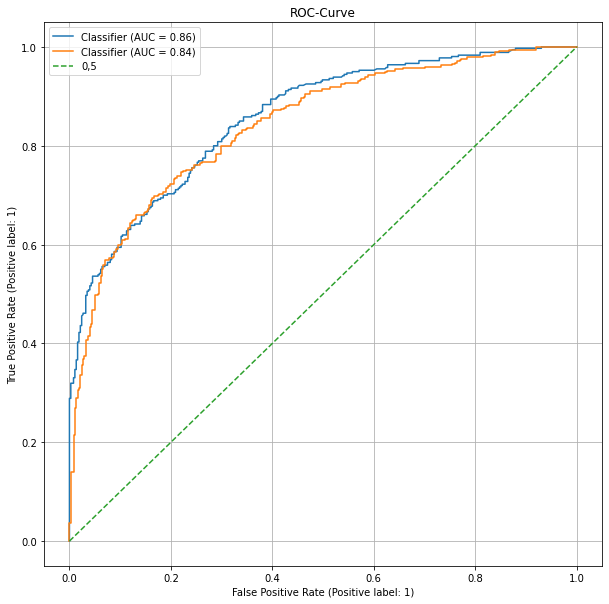

In [290]:
fig, ax = plt.subplots(figsize=(10, 10))
RocCurveDisplay.from_predictions(y_test2, pipe_grd2.predict_proba(X_test2)[
                                 :, -1], ax=ax)  # Гипотеза
RocCurveDisplay.from_predictions(
    y_test, pipe_over.predict_proba(X_test)[:, -1], ax=ax) #Модель из основной задачи
ax.plot([0, 1], [0, 1], label='0,5', linestyle='--')
ax.set_title('ROC-Curve')
ax.grid(True)
plt.legend()
plt.show()

Не все фичи нам важны, не все фичи нам нужны. Если выбросить фичи, которые в П. 2 были определены мной как шумовые/не нужные, то мы можем получить модель с лучшими параметрами. 

Так, я получил модель с f1-мерой на тесте =0,75, и roc_auc =0.8563. Как и в предыдущей моделе, рок растет лучше, чем f1-мера.

## Вывод

В заключении подытожу: в ходе проекта был проанализирован датасет исторических данных о поведении клиентов и расторжении договоров с банком.

Из анализа были определены наиболее важные для алгоритма предсказания фичи: 'Geography', 'Gender','NumOfProducts', 'IsActiveMember','Balance','Age'.

Был выполнен расчет модели с дисбалансом классов, по результатам которого были получены метрики f1-меры 0.562 , roc_auc=0,84.

По итогу борьбы с дисбалансом методом RandomUnderSampler, а так же построения оптимальной моедели при помощи GridSearchCV, и использовании оптимальных признаков была получена метрика f1-мера =0,76 на стесте и roc_auc=0.842 на тесте. Были построение roc кривые для расчетных моделей.
